In [7]:
import numpy as np
import pandas as pd
from network import *
from data_process import *
from util import *

import itertools
import matplotlib.pyplot as plt
import os

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

os.environ['CUDA_VISIBLE_DEVICES'] = "1"


In [15]:
def get_classes_name():
    dic = dic_ESC50()
    class_names = []
    for i in range(50):
        class_names.append(dic[i])
    return class_names


def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def test(model, test_pkl):
    model.eval()
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        wins_data = []
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent

            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
            wins_data.append(win_data)

        if len(wins_data) == 0:
            print(item['key'])

        wins_data = np.array(wins_data)

        wins_data = wins_data[:, np.newaxis, :]
        # print wins_data.shape

        data = torch.from_numpy(wins_data).type(torch.FloatTensor) # (N, 1L, 24002L)
        label = torch.LongTensor([label])


        data, label = data.cuda(), label.cuda()
        data, label = Variable(data, volatile=True), Variable(label)

        # print data.size()
        output = model(data)

#         output = torch.sum(output, dim=0, keepdim=True)
        output = torch.max(output, dim=0, keepdim=True)[0]
    

#         test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
#         y_true.append(label.data[0])
#         y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

#     test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
#     cnf_matrix = confusion_matrix(y_true, y_pred)
    
    
    print('\nTestACC: {}/{} {:.2f}%\n'.format(
        correct, len(sampleSet), test_acc))
    
    return test_acc

    
def test_logmel(model, test_pkl):
    model.eval()
    
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        
        feats = []
        
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent
            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
            
            melspec = librosa.feature.melspectrogram(win_data, 44100, n_fft=2048, hop_length=150, n_mels=64)  # (40, 442)
            logmel = librosa.logamplitude(melspec)[:,:441]  # (40, 441)
            delta = librosa.feature.delta(logmel)
            
            feat = np.stack((logmel, delta))
#             feat = logmel[np.newaxis, :]
            feats.append(feat)

        if len(feats) == 0:
            print(item['key'])

        feats = np.array(feats)
        
        data = torch.from_numpy(feats).type(torch.FloatTensor) 
        
        label = torch.LongTensor([label])


        data, label = data.cuda(), label.cuda()
        data, label = Variable(data, volatile=True), Variable(label)
        output = model(data)
        output = torch.sum(output, dim=0, keepdim=True)

#         test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
#         y_true.append(label.data[0])
#         y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

#     test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
#     cnf_matrix = confusion_matrix(y_true, y_pred)
    
    print('\nTestACC: {}/{} {:.2f}%\n'.format(
        correct, len(sampleSet), test_acc))
    
    return test_acc
    

def test_joint(model_wave, model_logmel, test_pkl):
    model_wave.eval()
    model_logmel.eval()
    
    test_loss = 0
    correct = 0
    y_pred = []
    y_true = []

    win_size = 66150
    stride = int(44100 * 0.2)
    sampleSet = load_data(test_pkl)

    for item in sampleSet:
        label = item['label']
        record_data = item['data']
        wins_data = []
        feats = []
        for j in range(0, len(record_data) - win_size + 1, stride):

            win_data = record_data[j: j+win_size]
            # Continue if cropped region is silent
            maxamp = np.max(np.abs(win_data))
            if maxamp < 0.005:
                continue
                
            wins_data.append(win_data)
            
            melspec = librosa.feature.melspectrogram(win_data, 44100, n_fft=2048, hop_length=150, n_mels=96)  # (40, 442)
            logmel = librosa.logamplitude(melspec)[:,:441]
#             delta = librosa.feature.delta(logmel)
            
#             feat = np.stack((logmel, delta))
            feat = logmel[np.newaxis, :]
            feats.append(feat)

        if len(wins_data) == 0:
            print(item['key'])

        wins_data = np.array(wins_data)
        feats = np.array(feats)
        
        wins_data = wins_data[:, np.newaxis, :]
        # print wins_data.shape

        data_wave = torch.from_numpy(wins_data).type(torch.FloatTensor) 
        data_logmel = torch.from_numpy(feats).type(torch.FloatTensor) 
        
        label = torch.LongTensor([label])


        data_wave, data_logmel, label = data_wave.cuda(), data_logmel.cuda(), label.cuda()
        data_wave, data_logmel, label = Variable(data_wave, volatile=True), Variable(data_logmel, volatile=True), Variable(label)

        # print data.size()
        output_wave = model_wave(data_wave)
        output_logmel = model_logmel(data_logmel)
        
        output_wave = torch.sum(output_wave, dim=0, keepdim=True)
        output_logmel = torch.sum(output_logmel, dim=0, keepdim=True)
        
        w, u = 0.5, 0.5
        output = w * output_wave + u * output_logmel
#         print output
        # print output

        test_loss += F.cross_entropy(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        y_true.append(label.data[0])
        y_pred.append(pred.cpu().numpy()[0][0])
        
        correct += pred.eq(label.data.view_as(pred)).sum()

    test_loss /= len(sampleSet)
    test_acc = 100. * correct / len(sampleSet)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    print('\nTest set: Average loss: {:.4f}, TestACC: {}/{} {:.2f}%\n'.format(
        test_loss, correct, len(sampleSet), test_acc))
    
    return test_acc, cnf_matrix


In [13]:
class_names = get_classes_name()
print(class_names)

['Hand saw', 'Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat', 'Hen', 'Insects (flying)', 'Sheep', 'Crow', 'Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops', 'Wind', 'Pouring water', 'Toilet flush', 'Thunderstorm', 'Crying baby', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps', 'Laughing', 'Brushing teeth', 'Snoring', 'Drinking - sipping', 'Door knock', 'Mouse click', 'Keyboard typing', 'Door - wood creaks', 'Can opening', 'Washing machine', 'Vacuum cleaner', 'Clock alarm', 'Clock tick', 'Glass breaking', 'Helicopter', 'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train', 'Church bells', 'Airplane', 'Fireworks']


### 单独测试wave特征

In [6]:
test_acc = []
for fold_num in range(5):
    model_name = '../model/M9_v2_fold' + str(fold_num) + '_v2_epoch160.pkl'
    model = torch.load(model_name)
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_valid.cPickle'
    acc = test(model, testPkl)
    test_acc.append(acc)
    


TestACC: 240/400 60.00%


TestACC: 233/400 58.25%


TestACC: 255/400 63.75%


TestACC: 268/400 67.00%


TestACC: 266/400 66.50%



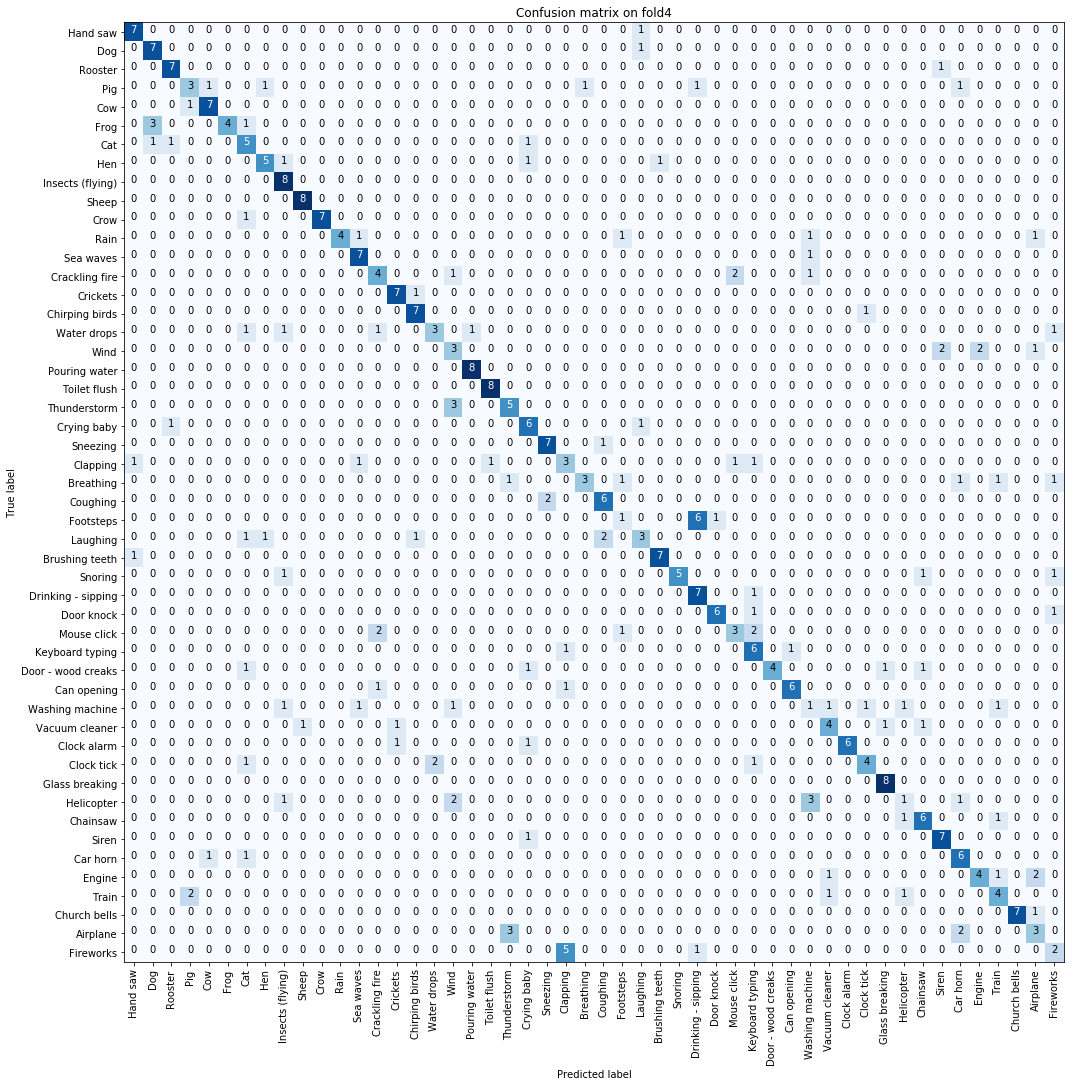

In [6]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix on fold' + str(fold_num))

plt.show()


### 单独测试logmel特征

In [7]:
test_acc = []
for fold_num in range(5):
    model_name = '../model/M9Logmel_fold' + str(fold_num) + '_v1_epoch100.pkl'
    model = torch.load(model_name)
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_valid.cPickle'
    acc = test_logmel(model, testPkl)
    test_acc.append(acc)


TestACC: 247/400 61.75%


TestACC: 259/400 64.75%


TestACC: 258/400 64.50%


TestACC: 286/400 71.50%


TestACC: 276/400 69.00%



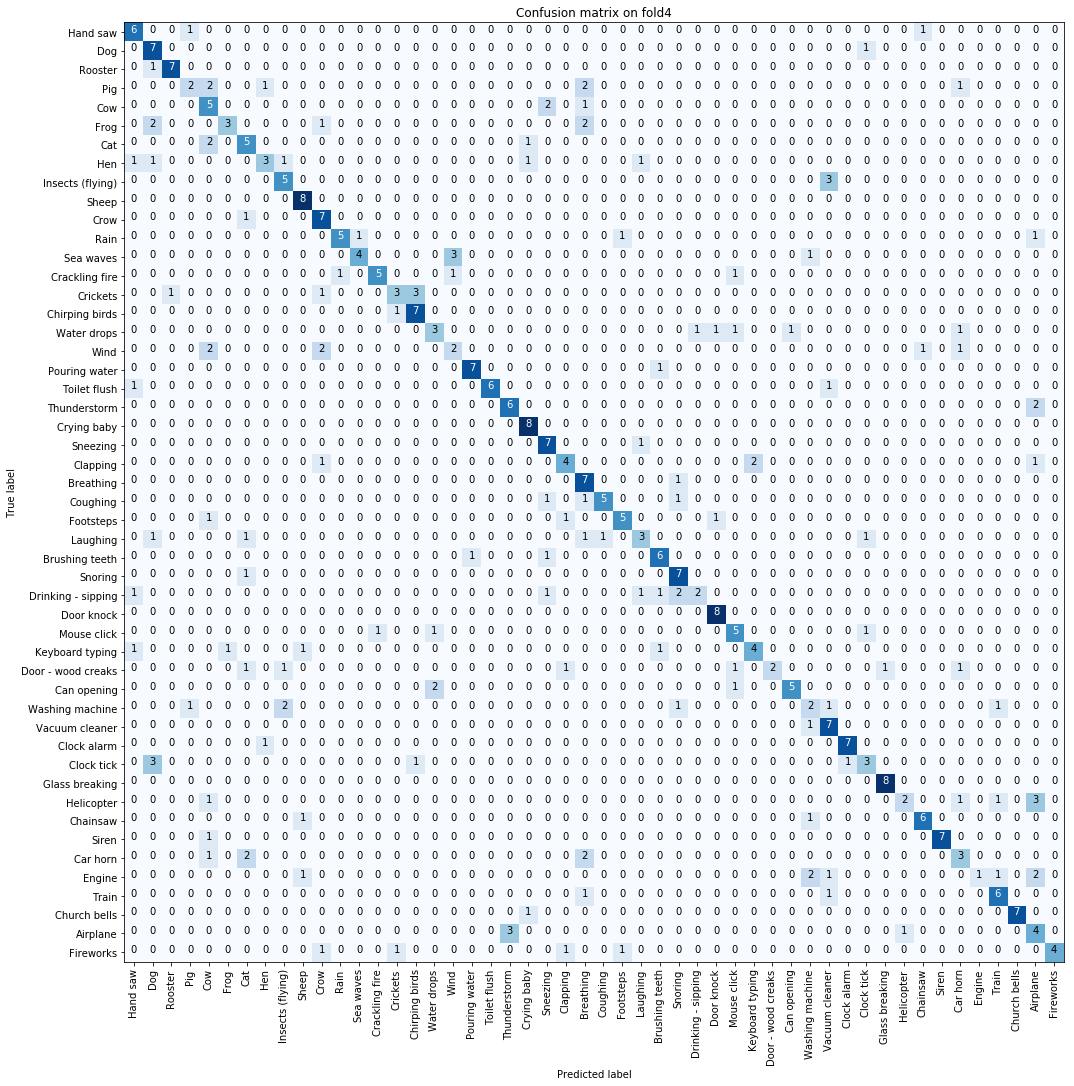

In [8]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix on fold' + str(fold_num))

plt.show()

### wave和logmel特征共同测试

In [16]:
test_acc = []
for fold_num in range(5):
    model_wave_name = '../model/M9_fixed_logmel_fold' + str(fold_num) + '_p1_v3_more.pkl'
    model_logmel_name = '../model/M9Logmel_v3_fold' + str(fold_num) + '_more.pkl'
    
    model_wave = torch.load(model_wave_name) 
    model_logmel = torch.load(model_logmel_name)
    
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
    acc, cnf_matrix = test_joint(model_wave, model_logmel, testPkl)
    test_acc.append(acc)
    
#     np.set_printoptions(precision=2)

#     # Plot non-normalized confusion matrix
#     plt.figure(figsize=(15, 15))
#     plot_confusion_matrix(cnf_matrix, classes=class_names,
#                           title='Confusion matrix on fold' + str(fold_num))

#     plt.show()


/home/zbq/work/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'network.M9_fixed_logmel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)



Test set: Average loss: 8.8561, TestACC: 316/400 79.00%


Test set: Average loss: 10.2825, TestACC: 315/400 78.75%


Test set: Average loss: 9.6519, TestACC: 326/400 81.50%


Test set: Average loss: 6.4051, TestACC: 322/400 80.50%


Test set: Average loss: 9.5891, TestACC: 304/400 76.00%



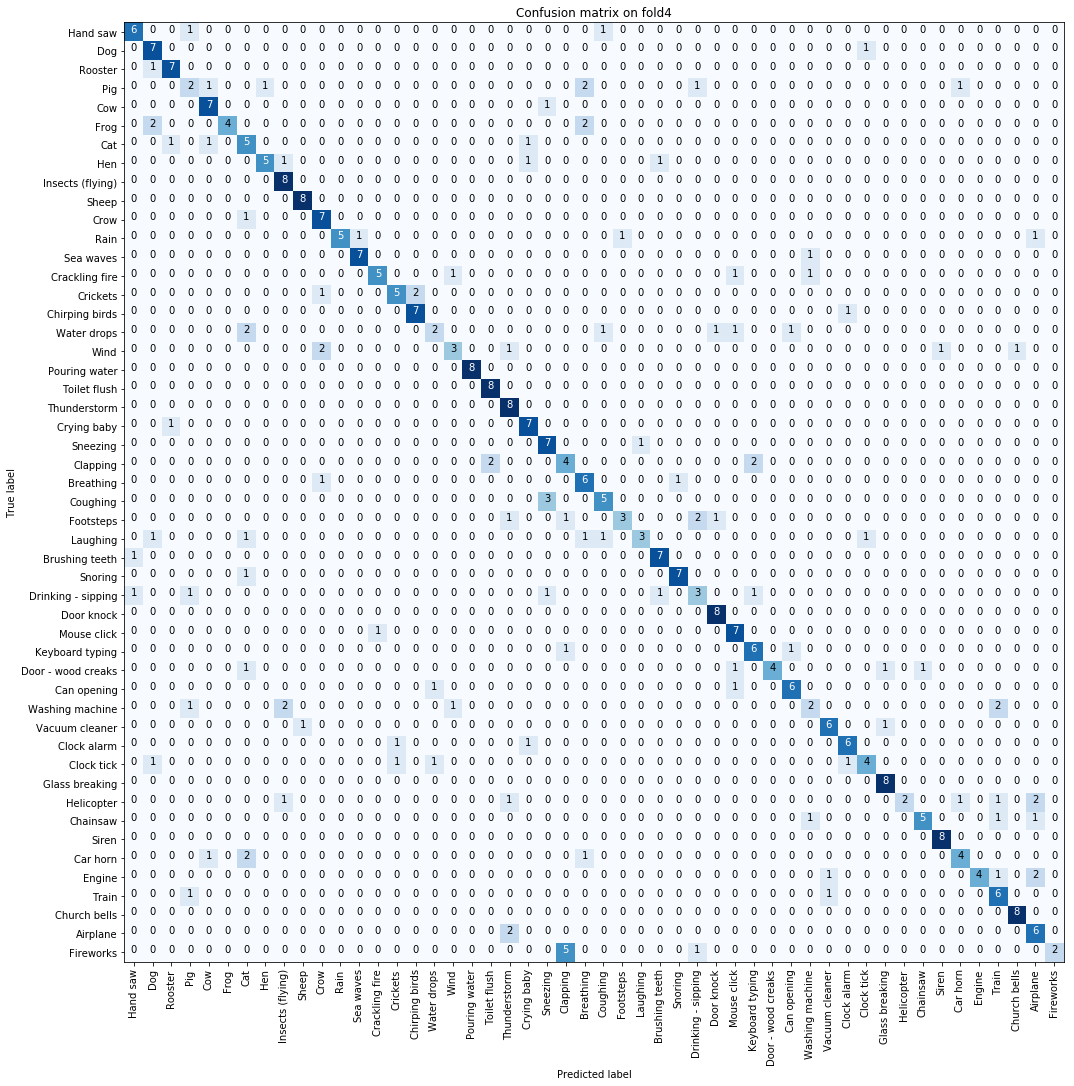

In [11]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix on fold' + str(fold_num))

plt.show()

### multiscale特征单独训练后概率相加

In [7]:
test_acc = []
for fold_num in range(5):
    model_srf_name = '../model/M9_srf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    model_mrf_name = '../model/M9_mrf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    model_lrf_name = '../model/M9_lrf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    
    model_srf = torch.load(model_srf_name) 
    model_mrf = torch.load(model_mrf_name)
    model_lrf = torch.load(model_lrf_name)
    
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
    acc, cnf_matrix = test_joint3(model_srf, model_mrf, model_lrf, testPkl)
    test_acc.append(acc)
    
#     np.set_printoptions(precision=2)

#     # Plot non-normalized confusion matrix
#     plt.figure(figsize=(15, 15))
#     plot_confusion_matrix(cnf_matrix, classes=class_names,
#                           title='Confusion matrix on fold' + str(fold_num))

#     plt.show()



Test set: Average loss: 51.0608, TestACC: 270/400 67.50%


Test set: Average loss: 47.6853, TestACC: 263/400 65.75%


Test set: Average loss: 41.5801, TestACC: 279/400 69.75%


Test set: Average loss: 33.7102, TestACC: 285/400 71.25%


Test set: Average loss: 43.5532, TestACC: 264/400 66.00%



### multiscale特征单独训练后与logmel模型概率相加

In [10]:
test_acc = []
for fold_num in range(5):
    model_srf_name = '../model/M9_srf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    model_mrf_name = '../model/M9_mrf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    model_lrf_name = '../model/M9_lrf_fold' + str(fold_num) + '_v1_epoch160.pkl'
    model_logmel_name = '../model/M9Logmel_fold' + str(fold_num) + '_v1_epoch100.pkl'
    
    model_srf = torch.load(model_srf_name) 
    model_mrf = torch.load(model_mrf_name)
    model_lrf = torch.load(model_lrf_name)
    model_logmel = torch.load(model_logmel_name)
    
    testPkl = '../data_wave_44100/fold' + str(fold_num) + '_test.cPickle'
    acc, cnf_matrix = test_joint4(model_srf, model_mrf, model_lrf, model_logmel, testPkl)
    test_acc.append(acc)
    
#     np.set_printoptions(precision=2)

#     # Plot non-normalized confusion matrix
#     plt.figure(figsize=(15, 15))
#     plot_confusion_matrix(cnf_matrix, classes=class_names,
#                           title='Confusion matrix on fold' + str(fold_num))

#     plt.show()



Test set: Average loss: 52.0070, TestACC: 303/400 75.75%


Test set: Average loss: 52.7684, TestACC: 293/400 73.25%


Test set: Average loss: 47.2480, TestACC: 308/400 77.00%


Test set: Average loss: 38.8772, TestACC: 303/400 75.75%


Test set: Average loss: 48.9153, TestACC: 289/400 72.25%



In [7]:
test_acc.extend([np.average(test_acc), np.std(test_acc)])
df = pd.DataFrame([test_acc])
df.columns = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4', 'average', 'std']
df.index = ['Test']
df.head()

,fold0,fold1,fold2,fold3,fold4,average,std
Test,60.0,58.25,63.75,67.0,66.5,63.1,3.473471


# 